In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import optimizers
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import math

In [15]:
data_path = 'data.csv'
df = pd.read_csv(data_path)

In [16]:
df.head()

,Layer-1,Layer-2,Ana-1,Ana-2,Thickness,WaveLength,Core_Real,CoreImag,TotalPower,CorePower,EffectiveArea,EML,CLoss
0,Au,TiO2,1.33,1.33,40,1500.0,1.4327,-3.380000e-09,5.240000e-10,5.230000e-10,1.940000e-11,19.9,0.12289
1,Au,TiO2,1.33,1.33,40,1520.0,1.4322,-4.400000e-09,5.030000e-10,5.010000e-10,1.660000e-11,19.9,0.15782
2,Au,TiO2,1.33,1.33,40,1540.0,1.4316,-5.840000e-09,4.960000e-10,4.940000e-10,1.570000e-11,19.9,0.20700
3,Au,TiO2,1.33,1.33,40,1560.0,1.4311,-8.070000e-09,4.930000e-10,4.920000e-10,1.650000e-11,19.9,0.28230
4,Au,TiO2,1.33,1.33,40,1580.0,1.4305,-1.190000e-08,4.630000e-10,4.620000e-10,1.990000e-11,19.9,0.41038


In [17]:
df.shape

(5527, 13)

In [18]:
dummy_fields = ["Layer-1","Layer-2"]

for each in dummy_fields:
    dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
    df = pd.concat([df,dummies], axis=1)

In [19]:
fields_to_drop = ["Layer-1","Layer-2"]
df = df.drop(fields_to_drop, axis=1)

In [20]:
df.head()

,Ana-1,Ana-2,Thickness,WaveLength,Core_Real,CoreImag,TotalPower,CorePower,EffectiveArea,EML,CLoss,Layer-1_AU,Layer-1_Au,Layer-1_Au+Ta2O5,Layer-1_TiO2,Layer-2_Au,Layer-2_TIO2,Layer-2_Ta2O5,Layer-2_TiO2
0,1.33,1.33,40,1500.0,1.4327,-3.380000e-09,5.240000e-10,5.230000e-10,1.940000e-11,19.9,0.12289,0,1,0,0,0,0,0,1
1,1.33,1.33,40,1520.0,1.4322,-4.400000e-09,5.030000e-10,5.010000e-10,1.660000e-11,19.9,0.15782,0,1,0,0,0,0,0,1
2,1.33,1.33,40,1540.0,1.4316,-5.840000e-09,4.960000e-10,4.940000e-10,1.570000e-11,19.9,0.20700,0,1,0,0,0,0,0,1
3,1.33,1.33,40,1560.0,1.4311,-8.070000e-09,4.930000e-10,4.920000e-10,1.650000e-11,19.9,0.28230,0,1,0,0,0,0,0,1
4,1.33,1.33,40,1580.0,1.4305,-1.190000e-08,4.630000e-10,4.620000e-10,1.990000e-11,19.9,0.41038,0,1,0,0,0,0,0,1


In [21]:
for each in df.columns:
  print(each,' '*(20-len(each)), df[each].isnull().values.any())

Ana-1                 False
Ana-2                 False
Thickness             False
WaveLength            False
Core_Real             False
CoreImag              False
TotalPower            False
CorePower             False
EffectiveArea         False
EML                   False
CLoss                 False
Layer-1_AU            False
Layer-1_Au            False
Layer-1_Au+Ta2O5      False
Layer-1_TiO2          False
Layer-2_Au            False
Layer-2_TIO2          False
Layer-2_Ta2O5         False
Layer-2_TiO2          False


In [22]:
tar = ['Core_Real', 'CoreImag', 'TotalPower', 'CorePower','EML', 'CLoss']
# tar = ['CLoss']
x = df[["Layer-1_Au",	"Layer-1_Au+Ta2O5",	"Layer-1_TiO2",	"Layer-2_Au",	"Layer-2_Ta2O5",	"Layer-2_TiO2","Ana-1","Ana-2","Thickness","WaveLength"]]
y = df[tar]

In [23]:
x.head()

,Layer-1_Au,Layer-1_Au+Ta2O5,Layer-1_TiO2,Layer-2_Au,Layer-2_Ta2O5,Layer-2_TiO2,Ana-1,Ana-2,Thickness,WaveLength
0,1,0,0,0,0,1,1.33,1.33,40,1500.0
1,1,0,0,0,0,1,1.33,1.33,40,1520.0
2,1,0,0,0,0,1,1.33,1.33,40,1540.0
3,1,0,0,0,0,1,1.33,1.33,40,1560.0
4,1,0,0,0,0,1,1.33,1.33,40,1580.0


In [24]:
quant_features = tar
scaled_features = {}

for each in quant_features:
    mean, std = y[each].mean(), y[each].std()
    scaled_features[each] = [mean, std]
    y.loc[:, each] = (y[each] - mean)/std 

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1088\3167035514.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[:, each] = (y[each] - mean)/std
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1088\3167035514.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[:, each] = (y[each] - mean)/std
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1088\3167035514.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [25]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=45)

In [35]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [27]:
np.shape(y_train), np.shape(X_train)

((4421, 6), (4421, 10))

In [39]:
def get_model():
    model = Sequential()
    model.add(Dense(128, kernel_initializer='normal', input_dim = 10, activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='linear'))
    return model


In [155]:
# schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
#         [300, 14000,45000], [0.001, 0.0001,0.00001,0.000001])

def set_model(model):
    ada = optimizers.Adam(
        learning_rate=0.0003,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name="Adam"
    )

    model.compile(loss='mse', optimizer=ada, metrics=['mae', 'mse'])
    model.summary()

In [156]:
from sklearn.model_selection import KFold

In [157]:
model = get_model()
set_model(model)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 128)               1408      
                                                                 
 dense_55 (Dense)            (None, 64)                8256      
                                                                 
 dense_56 (Dense)            (None, 128)               8320      
                                                                 
 dense_57 (Dense)            (None, 128)               16512     
                                                                 
 dense_58 (Dense)            (None, 32)                4128      
                                                                 
 dense_59 (Dense)            (None, 6)                 198       
                                                                 
Total params: 38,822
Trainable params: 38,822
Non-trai

In [149]:
BATCH_SIZE = 64
EPOCHS = 5
N_SPLIT = 7
loss = []
mae = []

In [150]:
kf = KFold(n_splits=N_SPLIT)
kf.get_n_splits(X_train)
for train_idx, test_idx in kf.split(X_train):
    trainX, ValX = X_train[train_idx], X_train[[test_idx]]
    trainY, ValY = y_train[train_idx], y_train[[test_idx]]
#     print(np.shape(trainX), np.shape(trainY))
#     print(np.shape(valX), np.shape(valY))
#     print()
    
    history = model.fit(
    trainX, 
    trainY, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split = 0.2)
    
    scores = model.evaluate(ValX, ValY, verbose=0)
    print(f'Score for fold {j}: MSE = {scores[0]}; MAE = {scores[1]}')
    loss.append(scores[0])
    mae.append(scores[1])

Epoch 1/5
48/48 [==============================] - 0s 2ms/step - loss: 0.0279 - mae: 0.0715 - mse: 0.0279 - val_loss: 0.0823 - val_mae: 0.0799 - val_mse: 0.0823
Epoch 2/5
 1/48 [..............................] - ETA: 0s - loss: 0.0218 - mae: 0.0751 - mse: 0.0218

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1088\5028751.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  trainX, ValX = X_train[train_idx], X_train[[test_idx]]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1088\5028751.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  trainY, ValY = y_train[train_idx], y_train[[test_idx]]


48/48 [==============================] - 0s 2ms/step - loss: 0.0257 - mae: 0.0679 - mse: 0.0257 - val_loss: 0.0791 - val_mae: 0.0801 - val_mse: 0.0791
Epoch 3/5
48/48 [==============================] - 0s 1ms/step - loss: 0.0267 - mae: 0.0686 - mse: 0.0267 - val_loss: 0.0781 - val_mae: 0.0793 - val_mse: 0.0781
Epoch 4/5
48/48 [==============================] - 0s 1ms/step - loss: 0.0258 - mae: 0.0680 - mse: 0.0258 - val_loss: 0.0775 - val_mae: 0.0803 - val_mse: 0.0775
Epoch 5/5
48/48 [==============================] - 0s 1ms/step - loss: 0.0244 - mae: 0.0650 - mse: 0.0244 - val_loss: 0.0769 - val_mae: 0.0773 - val_mse: 0.0769
Score for fold 5: MSE = 0.07534105330705643; MAE = 0.06875649839639664
Epoch 1/5
48/48 [==============================] - 0s 2ms/step - loss: 0.0364 - mae: 0.0710 - mse: 0.0364 - val_loss: 0.0809 - val_mae: 0.0808 - val_mse: 0.0809
Epoch 2/5
48/48 [==============================] - 0s 1ms/step - loss: 0.0402 - mae: 0.0790 - mse: 0.0402 - val_loss: 0.0834 - val_mae

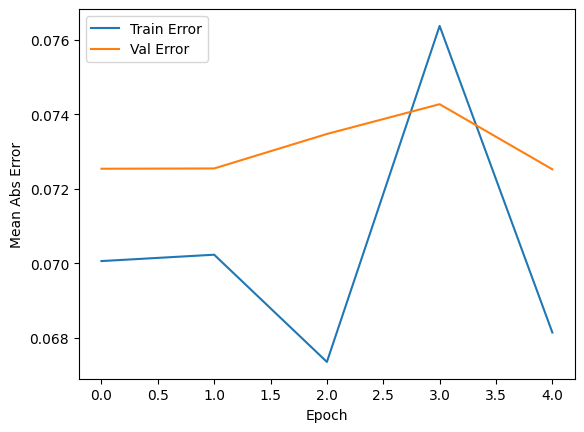

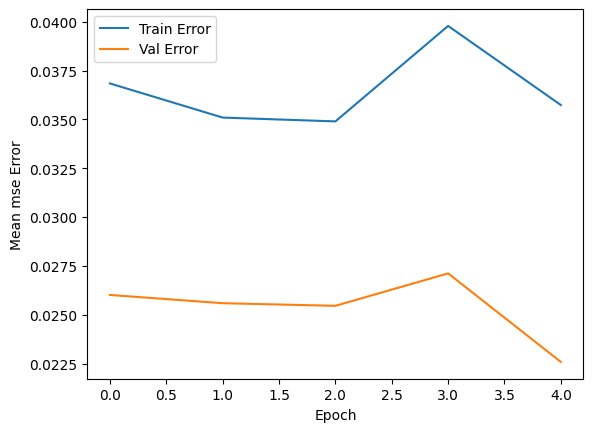

In [151]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
#   hist.to_csv('Adamax(10000).csv')
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean mse Error')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
  plt.legend()

plot_history(history)  


In [152]:
# model.save("updatedModel.h5")

In [153]:
# from numpy import loadtxt
# from tensorflow.keras.models import load_model
 
# # load model
# model = load_model('model.h5')
# # summarize model.
# model.summary()
# # load dataset

In [154]:
pre = model.predict(X_test)
y = y_test

cnt=0

print()    
for i in range(len(pre)):
#       print(y[i],'\t', pre[i],'\t', abs(y[i] - pre[i]))
      cnt = cnt + abs(y[i] - pre[i])
    
for l in range(6):
    print(tar[l], '\t',metrics.r2_score(y[:,l], pre[:,l]), '\t',cnt[l])    

print('ERROR :', metrics.mean_squared_error(y,pre))


35/35 [==============================] - 0s 500us/step

Core_Real 	 0.9889162499969205 	 61.40661180280312
CoreImag 	 0.988034220076995 	 47.53622952901852
TotalPower 	 0.9904172537485418 	 59.303148015236246
CorePower 	 0.9906034969678161 	 58.844709708087606
EML 	 0.895075941207373 	 210.21044550584986
CLoss 	 0.9877352879766946 	 53.66335645462986
ERROR : 0.024155917429213396


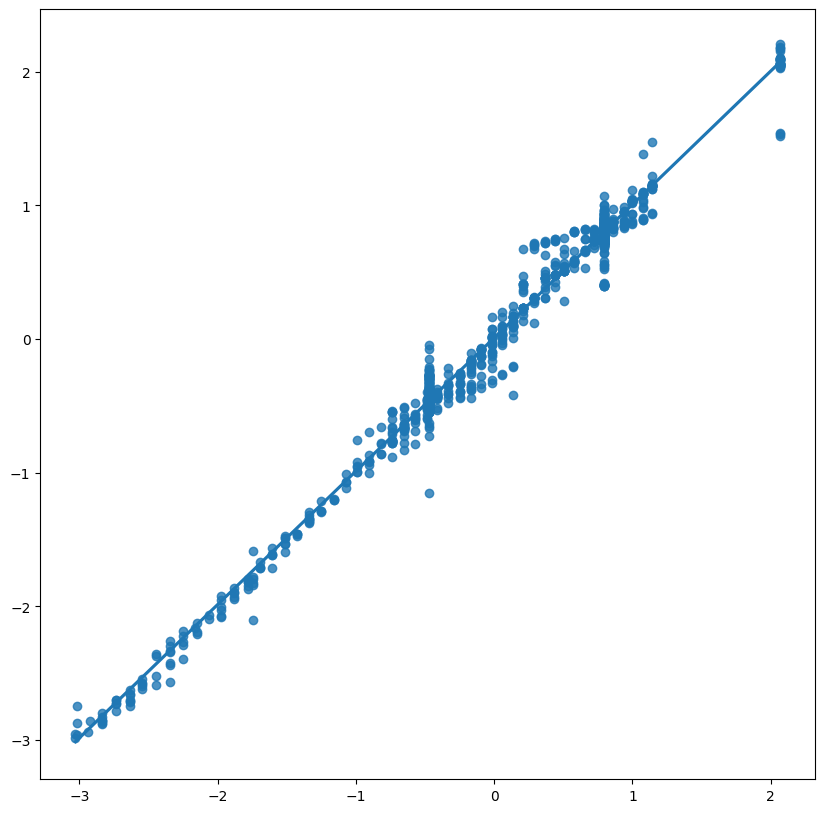

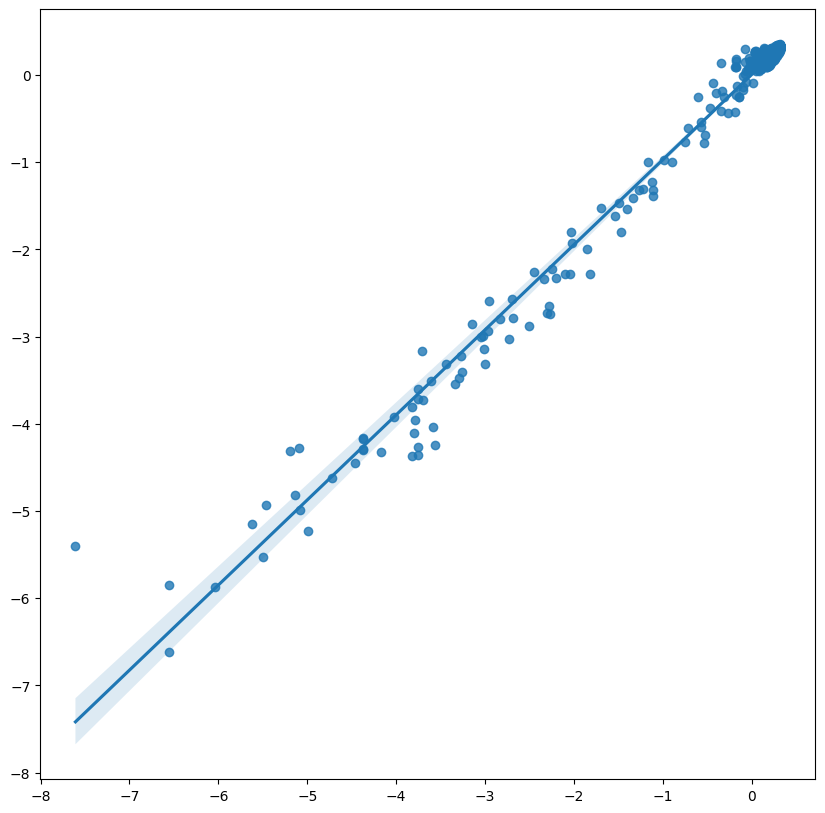

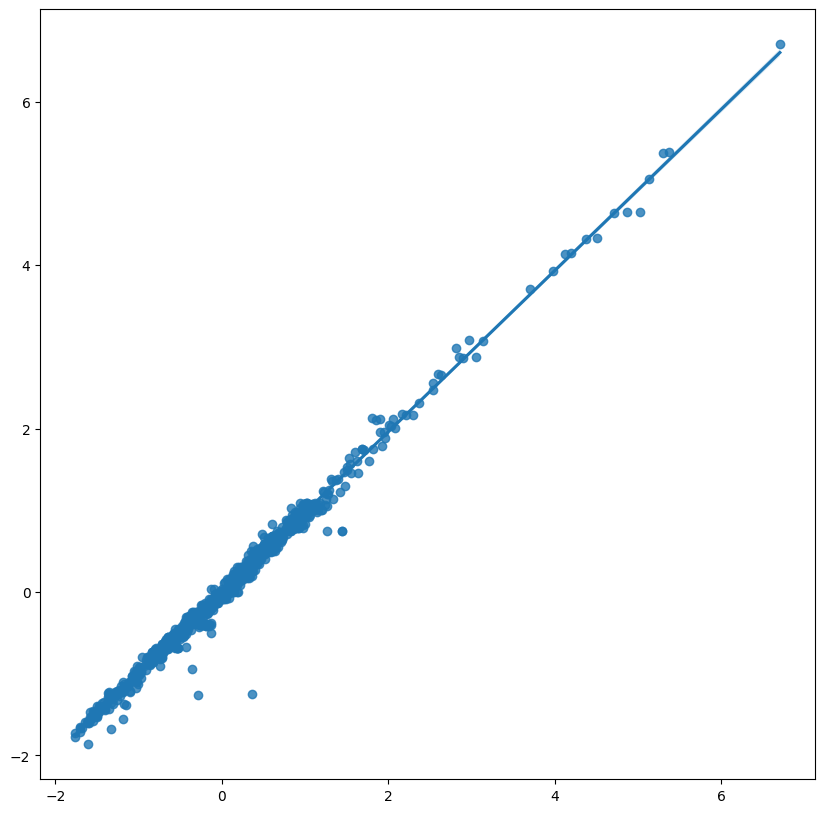

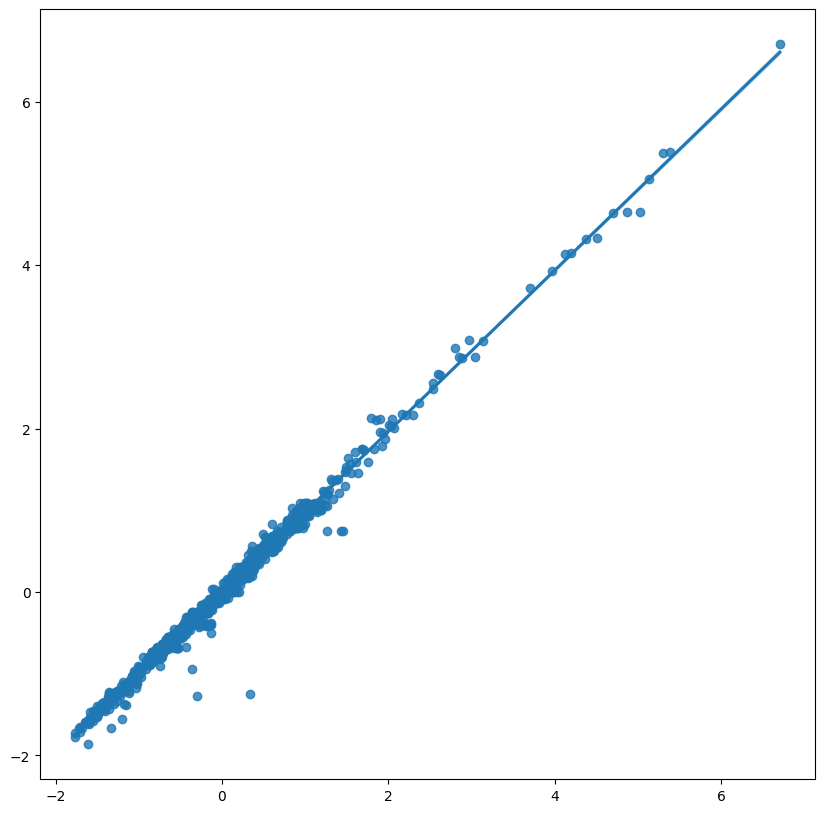

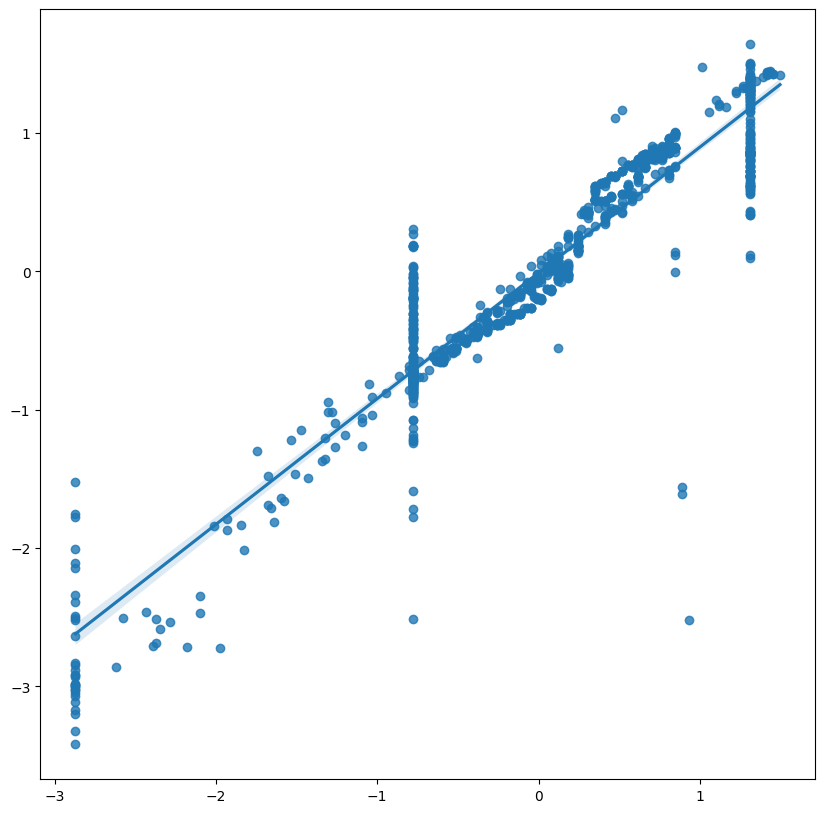

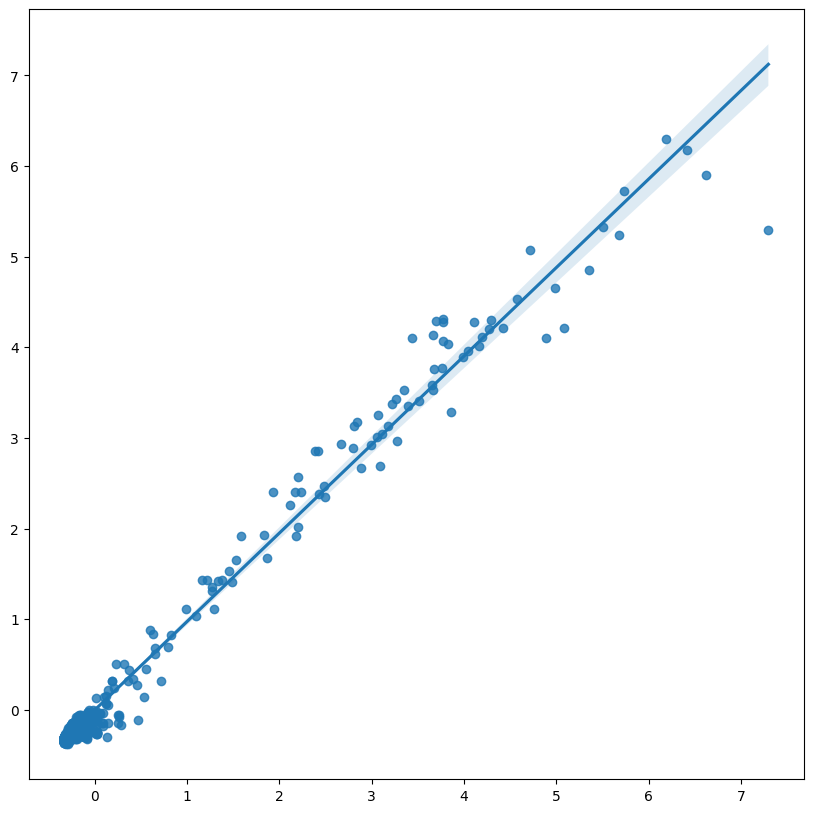

In [148]:
for l in range(6):
#     print(tar[l], metrics.r2_score(y[:,l], pre[:,l]))

    plt.figure(figsize=(10,10))
    sns.regplot(x=y[:,l], y=pre[:,l])

In [ ]:
y